# QPSK Implementation

In [21]:
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Union
from numpy.typing import NDArray

In [22]:
VMAX = 5
BAUD_RATE = 1000  # symbols per second

In [23]:
def Msg_to_Bin(msg: str) -> List[str]:
    return [format(ord(char), '08b') for char in msg]

def group_bits(binary_list: List[str]) -> List[str]:
    """
    Group bits into dibits (2 bits per symbol) for QPSK
    """
    # Flatten binary list and ensure even length
    bits = ''.join(binary_list)
    # Group into dibits
    return [bits[i:i+2] for i in range(0, len(bits)-1, 2)]

def Symbol_Mapping(dibit: str) -> float:
    """
    Maps 2 bits (dibit) to QPSK symbol.
    "00" -> 1-1j  (-45°)
    "01" -> -1-1j  (-135°)
    "10" -> -1+1j   (135°)
    "11" -> 1+1j   (45°)
    """
    mapping = {"00" : 1-1j , "01": -1-1j, "10": -1+1j, "11": 1+1j}
    return VMAX * mapping[dibit]

def Carrier_Signal(f_c: float, f_s: float, time: float) -> tuple[NDArray[np.float64], NDArray[np.float64]]:
    """
    Generate In-phase and Quadrature carriers
    """
    t = np.arange(0, time, 1/f_s)
    # In-phase carrier (cosine)
    i_carrier = np.cos(2 * np.pi * f_c * t)
    # Quadrature carrier (sine)
    q_carrier = np.sin(2 * np.pi * f_c * t)
    return i_carrier, q_carrier

In [24]:
def QPSK_Modulation(Symbols: List[complex], 
                    I_Carrier: NDArray[np.float64],
                    Q_Carrier: NDArray[np.float64], 
                    samples_per_symbol: int) -> NDArray[np.float64]:
    """
    QPSK modulation:
    - Separate real (I) and imaginary (Q) parts of symbols
    - Upsample both components
    - Multiply with respective carriers
    - Sum the modulated signals
    """
    # Separate I and Q components
    i_symbols = np.real(Symbols)
    q_symbols = np.imag(Symbols)
    
    # Upsample symbols
    i_upsampled = np.repeat(i_symbols, samples_per_symbol)
    q_upsampled = np.repeat(q_symbols, samples_per_symbol)
    
    # Trim to match carrier length
    min_length = min(len(i_upsampled), len(I_Carrier))
    i_upsampled = i_upsampled[:min_length]
    q_upsampled = q_upsampled[:min_length]
    i_carrier = I_Carrier[:min_length]
    q_carrier = Q_Carrier[:min_length]
    
    # Modulate I and Q components and combine
    return i_upsampled * i_carrier - q_upsampled * q_carrier

In [38]:
def plot_signals(modulated: np.ndarray, f_s: float, symbols: List[complex]) -> None:
    """
    Plot QPSK modulated signal in time domain and an enhanced constellation diagram.
    
    Parameters:
    modulated (np.ndarray): The QPSK modulated signal.
    f_s (float): Sampling frequency.
    symbols (List[complex]): List of complex numbers representing QPSK symbols.
    """
    # Time axis for the modulated signal
    t = np.arange(len(modulated)) / f_s
    
    # Set up a 2x1 subplot layout
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot the QPSK modulated signal (time domain)
    ax1.plot(t, modulated, color='blue')
    ax1.set_title('QPSK Modulated Signal')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True)
    
    # Enhanced constellation diagram for QPSK
    symbol_array = np.array(symbols)
    real_parts = np.real(symbol_array)
    imag_parts = np.imag(symbol_array)
    
    # Scatter plot with circles and origin lines for clarity
    ax2.scatter(real_parts, imag_parts, s=80, color='b', edgecolor='k', zorder=4)
    
    # Draw dashed lines from each point to the origin for phase clarity
    for symbol in symbol_array:
        ax2.plot([0, symbol.real], [0, symbol.imag], 'k--', alpha=0.5)
    
    # Plot quadrant lines
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax2.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
    
    # Add labels for each constellation point (dibits, if mapped correctly)
    dibit_labels = ['01', '00', '11', '10']  # Standard QPSK labeling
    for i, symbol in enumerate(np.unique(symbol_array)):
        ax2.text(symbol.real, symbol.imag, f'{dibit_labels[i]}', ha='left', va='top', 
                 color='white', fontsize=12, fontweight='bold', bbox=dict(facecolor='red', edgecolor='none', pad=1.5))
    
    # Set limits, grid, and title for the constellation diagram
    ax2.set_xlim(-6, 6)
    ax2.set_ylim(-6, 6)
    ax2.set_aspect('equal')
    ax2.set_title("Enhanced QPSK Constellation Diagram")
    ax2.set_xlabel('In-Phase (I)')
    ax2.set_ylabel('Quadrature (Q)')
    ax2.grid(True)
    
    # Adjust layout and show the combined figure
    plt.tight_layout()
    plt.show()

In [26]:
def main() -> None:
    message = "Test"
    f_c = 1000  # Carrier frequency (Hz)
    f_s = 16000 # Sampling frequency (Hz)
    time = 1    # Time duration (seconds)

    # Convert message to binary and group into dibits
    binary_seq = Msg_to_Bin(message)
    dibits = group_bits(binary_seq)
    
    # Map dibits to QPSK symbols
    symbols = [Symbol_Mapping(dibit) for dibit in dibits]
    
    # Generate carriers
    i_carrier, q_carrier = Carrier_Signal(f_c, f_s, time)
    
    # Calculate samples per symbol
    samples_per_symbol = int(f_s / BAUD_RATE)
    
    # Modulate
    qpsk_signal = QPSK_Modulation(symbols, i_carrier, q_carrier, samples_per_symbol)
    
    # Plot results
    plot_signals(qpsk_signal, f_s, symbols)
    
    # Print debug info
    print(f"Binary sequence: {binary_seq}")
    print(f"Dibits: {dibits}")
    print(f"Symbols: {symbols}")
    print(f"Modulated signal length: {len(qpsk_signal)}")

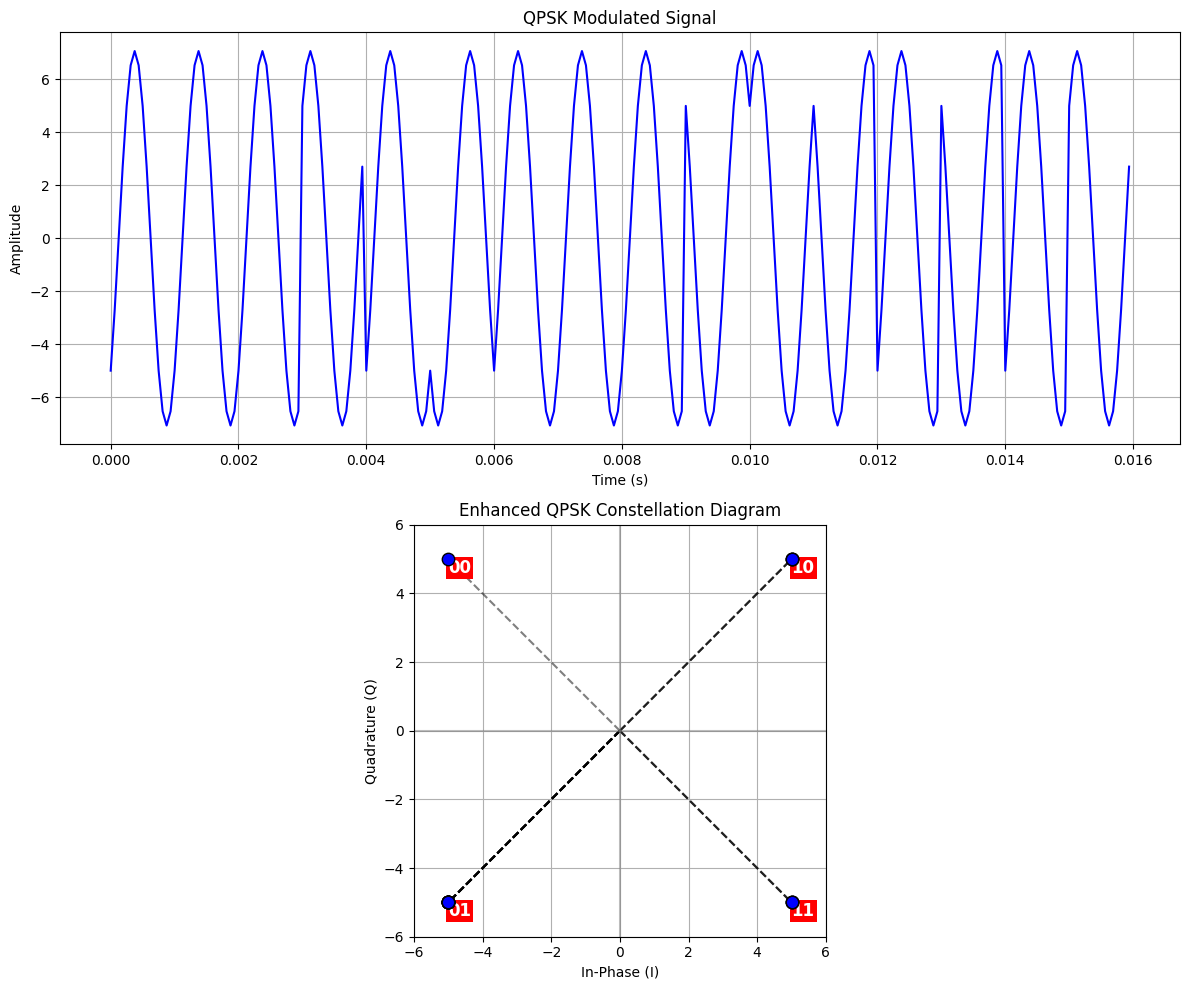

Binary sequence: ['01010100', '01100101', '01110011', '01110100']
Dibits: ['01', '01', '01', '00', '01', '10', '01', '01', '01', '11', '00', '11', '01', '11', '01', '00']
Symbols: [(-5-5j), (-5-5j), (-5-5j), (5-5j), (-5-5j), (-5+5j), (-5-5j), (-5-5j), (-5-5j), (5+5j), (5-5j), (5+5j), (-5-5j), (5+5j), (-5-5j), (5-5j)]
Modulated signal length: 256


In [39]:
if __name__ == "__main__":
    main()